## Setup colab

In [1]:
# From Computer vision lab 6, keeps reloading the code for the objects so that you can work on them without needing to reload the kernal
%load_ext autoreload
%autoreload 2

In [2]:
# From lab 7
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/DRL/DRL Coursework/'

import sys
sys.path.append(path)

Mounted at /content/gdrive


In [3]:
!pip install torch
!pip install -U "ray[rllib]" torch

     |████████████████████████████████| 53.2 MB 217 kB/s 
     |████████████████████████████████| 750.6 MB 10 kB/s 
     |████████████████████████████████| 144 kB 60.7 MB/s 
     |████████████████████████████████| 4.1 MB 40.0 MB/s 
     |████████████████████████████████| 8.8 MB 42.1 MB/s 
     |████████████████████████████████| 125 kB 63.1 MB/s 
     |████████████████████████████████| 1.2 MB 56.0 MB/s 
     |████████████████████████████████| 461 kB 69.7 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimato

# DQN with two improvements

In [2]:
# imports
import gym
from ray.rllib.env.env_context import EnvContext
import ray.rllib.agents.dqn as dqn
from helpers.advanced_map import AdvancedMap

from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from helpers.r_matrix import r_matrix
from helpers.get_available_actions import get_available_actions, adv_action_from_index
import numpy as np
import random
import pandas as pd
import subprocess

from multiprocessing import Pool

# for getting the videos
from matplotlib import rc
import matplotlib.animation as animation
rc('animation', html='jshtml')

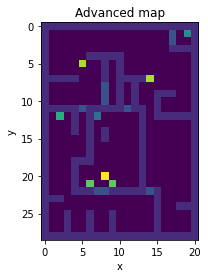

In [3]:
m = AdvancedMap()
m.displayImg()

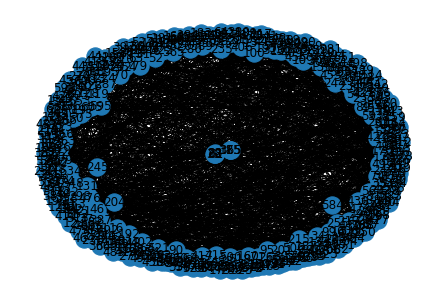

In [10]:
# using https://networkx.org/documentation/stable/tutorial.html
# initialise the graph
G = nx.Graph()

# Get the R Matrix to tell which states connect to other states
r = r_matrix(m.map)

# check whether the state has access to anythere and if it does then add it. Otherwise don't (this cuts down on the number of nodes)
ns = [y for y, row in enumerate(r) if len(get_available_actions(r, y)) > 0]
G.add_nodes_from(ns)

# start iterating through the R matrix to get the connections
for y, row in enumerate(r):
    for x, cellweight in enumerate(row):
        # if the cell isn't null add the edge and the weight
        if not np.isnan(cellweight):
            G.add_edge(y, x, weight=cellweight)

# draw the graph
nx.draw(G, with_labels=True)

# Remove the variables
del r
del G

### Advanced Map Wrapper

In [4]:
class AdvancedMapEnv(gym.Env):
  """Class that wraps the advanced map to make it compatible with RLLib
  
  Functions:
  __init__: takes in a config and creates the environment
  
  convert_observations: takes in a dictionary and returns a numpy array
  
  seed: set the random seed, with an optional integer
  
  step: take an action and see what happens
  
  reset: reset the environment back to the beginning"""
  
  def __init__(self, config: EnvContext):
    """Starts up the environment
    
    Inputs:
    config: an EnvContext"""
    # super(AdvancedMapEnv, self).__init__()
    # create an advanced map object
    self.advanced_map = AdvancedMap()

    # Define the action space
    # 5 actions: up, down, left, right, shoot
    self.action_space = gym.spaces.Discrete(5)

    # define the observation space, a 53 column box of floats between -1 and 1
    self.observation_space = gym.spaces.Box(low=-1., high=1., shape=[53,], dtype=np.float32)
  
  def reset(self) -> np.array:
      """Reset the environment and send back the observations"""
      # send through the reset command
      obs = self.advanced_map.reset(pos=None)
      # convert the observations
      return self.convert_observations(obs)
  
  def step(self, action: int):
    """take the step, assuming that the action is valid"""
    assert action in [0, 1, 2, 3, 4]

    # get the action
    actionstr = adv_action_from_index(action)

    # pass in the step
    obs = self.advanced_map.step(actionstr)

    rew = obs['immediate_reward']

    # return obs, reward and done
    return self.convert_observations(obs), rew, obs['is_stop'], {}

  def convert_observations(self, obs: dict) -> np.array:
    """Here we take in the dictionary of observations from the environment and returns a normalised numpy array
    
    The dictionary contains:
    is_stop: a boolean, used internally to determine whether to stop the episode
    immediate_reward: the points we got in the last round
    enemy_count: how many active enemies there are
    agent_view: the 7x7 view of the surroundings (values between 0-8)
    obj_direction: the relative direction to the objective (0-max width, 0-max height)
    agent_health: the health of the agent, between 0-100"""
    # sort out the relative coordinates, so that the directions are divided by the size of the environment
    obj_direction = np.divide(np.array(list(obs['obj_direction'])), np.array([21., 29.])) # TODO dynamically get the size

    # normalise the view of the surroundings
    agent_view = obs['agent_view'].ravel() / 8. # use ravel to reshape into a 1 row list and normalise it
    
    # enemy_count
    enemy_count = np.array(obs['enemy_count'] / 3.) # TODO dynamically get the max number of enemies
    
    # agent_health
    agent_health = np.array(obs['agent_health'] / 100.)
    
    # concatenate into a single numpy array, 1 row, 2 + 49 + 1 + 1 = 53 columns between -1 & 1
    return np.concatenate([obj_direction, agent_view, [enemy_count], [agent_health]])

    def seed(self, seed=None) -> None:
      """Set the random seed"""
      random.seed(seed)

## Start training


In [46]:
# helper functions
def training_loop(config: dict, csv_filename: str, checkpoint_folder: str, num_epochs=101, is_save=True, path="/content/gdrive/My Drive/Colab Notebooks/DRL/DRL Coursework/data") -> None:
  """Train a DQN from the provided config and save the data"""
  # setup the trainer
  trainer = dqn.DQNTrainer(config=config)

  # store the rewards
  ret = {
    'avg_rewards': [],
    'mean_q': []
  }

  for episode in range(num_epochs):
    # train an episode with DQN
    result = trainer.train()
    # print(result)
    ret['avg_rewards'].append(result['episode_reward_mean'])
    ret['mean_q'].append(result['info']['learner']['default_policy']['learner_stats']['mean_q'])

    if is_save:
      print(f"Episode {episode}, mean reward: {result['episode_reward_mean']}, mean Q: {ret['mean_q'][-1]}, all rewards: {result['hist_stats']['episode_reward']}")
    # early stopping if mean reward doesn't improve for a while (as it seems to improve and then get worse and then get much better, it may be best to not stop early)
    # from lab 7
    if episode % 10 == 0 and is_save:
      # checkpoint the model
      checkpoint = trainer.save()
      print("Checkpoint:", checkpoint)

  if is_save:
    # build the dataframe
    org_df = pd.DataFrame.from_dict(ret)

    # save the data
    org_df.to_csv(f"{path}/{csv_filename}.csv")
    # save the checkpoint (inspired by the Big Data saving pickles to cloud buckets)
    subprocess.run(['cp', checkpoint, f"{path}/{checkpoint_folder}/"], stderr=subprocess.PIPE)
    # save the metadata
    subprocess.run(['cp', checkpoint + '.tune_metadata', f"{path}/{checkpoint_folder}/"], stderr=subprocess.PIPE)
  else:
    return max(ret['avg_rewards'])

def graph_results(result_csv: str, path="/content/gdrive/My Drive/Colab Notebooks/DRL/DRL Coursework/data") -> None:
  """Retrieve the csv file and plot the results"""
  # build the dataframe
  df = pd.read_csv(f"{path}/{result_csv}.csv")
  # get rid of the useless column
  df.drop("Unnamed: 0", axis=1, inplace=True)

  # Build a graph of the mean rewards over time
  plt.scatter(df.index, df['avg_rewards'])
  plt.xlabel("Episode")
  plt.ylabel("Avg. reward")
  plt.title("Average rewards over time")
  plt.show()

  # Build a graph of mean Q
  plt.scatter(df.index, df['mean_q'])
  plt.title('Mean Q value over time')
  plt.xlabel('Episode')
  plt.ylabel('Mean Q value over time')
  plt.show()

def get_video(config: dict, path_to_agent: str, file_name:str) -> animation.FuncAnimation:
    """Here we create a video from the relevant agent and save it"""
    # visualise what the agent is doing
    # using code from https://docs.ray.io/en/latest/rllib/rllib-training.html (computing actions)
    # setup environment
    env = AdvancedMapEnv(config)
    # setup the agent and restore from the checkpoint
    agent = dqn.DQNTrainer(config=config)
    agent.restore(path_to_agent)

    # setup the variables to store the reward, whether it is done and the observations
    episode_reward = 0
    done = False
    obs = env.reset()
    # store the data for the video
    scene = []
    total_reward = []
    directions = []

    while not done:
        # work out the next action to take
        action = agent.compute_action(obs)
        # take the next action
        obs, reward, done, _ = env.step(action)
        # add the reward to the episode reward
        episode_reward += reward
        total_reward.append(episode_reward)
        # get the unnormalised data to show the view
        scene.append(env.advanced_map.agents_view())
        # get the relative direction to the next objective
        directions.append(env.advanced_map.direction_to_objective())

    # using code from Computer vision lab 5, animation
    fig, ax = plt.subplots()

    def frame(i: int):
        """Render a frame of the video"""
        # dispose of the last frame
        ax.clear()
        # get rid of the axis labels
        ax.axis('off')
        #fig.tight_layout()
        # render the agent's view
        plot = ax.imshow(scene[i])
        # get the commentary
        ax.set_title(f"Reward: {total_reward[i]}, direction to objective: {directions[i]}")
        return plot
    # build up the video
    anim = animation.FuncAnimation(fig, frame, frames=len(scene))

    # set the path to the ffmpeg program (install it using apt-get install ffmpeg, then use which ffmpeg to get where it installed to)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

    writervideo = animation.FFMpegWriter(fps=5) # from https://www.geeksforgeeks.org/how-to-save-matplotlib-animation/
    anim.save(f"videos/{file_name}.mp4", writer=writervideo)

    # dispose of the graph object
    plt.close()
    return anim

### Grid search

In [27]:
def train_from_search_params(params: tuple) -> float:
  """Here we create a config dictionary and pass it into the training loop"""
  cnf = dqn.DEFAULT_CONFIG.copy()
  cnf['framework'] = 'torch'
  # set the environment
  cnf['env'] = AdvancedMapEnv
  # disable duelling
  cnf['dueling'] = False
  # disable double Q
  cnf['double_q'] = False
  # use relu (REctified Linear Units) activation
  cnf['model']['post_fcnet_activation'] = 'relu'
  # get the hidden units from the parameters
  cnf['model']['fcnet_hiddens'] = params[0]

  # get gamma from the parameters
  cnf["gamma"] = params[1]

  # Disable environment checking so that it doesn't take forever
  cnf['disable_env_checking'] = True

  return training_loop(cnf, "null", "null", num_epochs=100, is_save=False)

def grid_search() -> tuple:
  """as the ray grid search doesn't want to work with modules, I am creating my own"""
  # define the parameters to loop through
  params = [(hiddens, gamma) for hiddens in [[128, 128], [64, 64], [256, 256], [128, 64]] for gamma in [x / 10 for x in range(0, 11, 1)]]

  # store the results
  ret = {
      'param': [],
      'max_reward': []
  }

  # map through each iteration using multiprocessing pool
  with Pool() as p:
    output = list(p.map(train_from_search_params, params))
  ret['param'] = params
  ret['max_reward'] = output
  return pd.DataFrame.from_dict(ret)
# run the grid search to see what the best parameters are
grid_search()

Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system monitoring.
Install gputil for GPU system moni

,param,max_reward
0,"([128, 128], 0.0)",-91.250000
1,"([128, 128], 0.1)",-84.030000
2,"([128, 128], 0.2)",-89.150000
3,"([128, 128], 0.3)",-76.810000
4,"([128, 128], 0.4)",-79.030000
5,"([128, 128], 0.5)",-78.800000
6,"([128, 128], 0.6)",-64.190000
7,"([128, 128], 0.7)",-58.360000
8,"([128, 128], 0.8)",-60.250000
9,"([128, 128], 0.9)",-43.220000


### No improvements

In [6]:
# get the default config to use
config = dqn.DEFAULT_CONFIG.copy()
# use torch
config['framework'] = 'torch'
# set the environment
config['env'] = AdvancedMapEnv
# disable duelling
config['dueling'] = False
# disable double Q
config['double_q'] = False
# set the hidden units to 64 then 64
#config['hiddens'] = [64, 64]
# use relu (REctified Linear Units) activation
config['model']['post_fcnet_activation'] = 'relu'
config['model']['fcnet_hiddens'] = [256, 256]
# set the gamma to 0.9, best parameter from the grid search
config['gamma'] = 0.9

In [9]:
# run the training loop
training_loop(config, 'DQNNoImprovement', 'NoImprovement', num_epochs=201, path="data")

2022-04-16 10:46:58,106	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 10:46:58,107	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 10:46:58,246	WARNING util.py:60 -- Install gputil for GPU system monitoring.


Episode 0, mean reward: -100.0, mean Q: -0.06947667896747589, all rewards: [-100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Checkpoint: /root/ray_results/DQNTrainer_AdvancedMapEnv_2022-04-16_10-46-58mflhutc9/checkpoint_000001/checkpoint-1
Episode 1, mean reward: -100.0, mean Q: -2.1280839443206787, all rewards: [-100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Episode 2, mean reward: -100.26666666666667, mean Q: -3.1189494132995605, all rewards: [-100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -108.0, -100.0, -100.0]
Episode 3, mean reward: -100.1951219512195, mean Q: -4.034618854522705, all rewards: [-100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, 

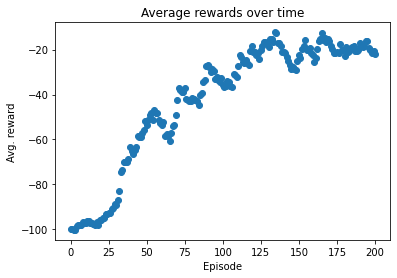

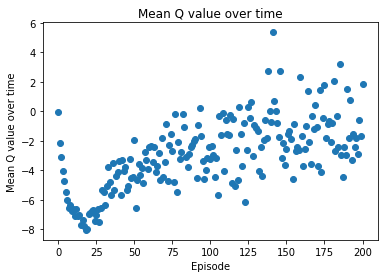

In [10]:
graph_results('DQNNoImprovement', path='data')

In [43]:
# Get a video of what the agent is doing
get_video(config, "data/NoImprovement/checkpoint-201", "NoImprovement")

2022-04-16 13:58:35,405	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 13:58:35,406	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 13:58:35,474	WARNING util.py:60 -- Install gputil for GPU system monitoring.
2022-04-16 13:58:35,563	INFO trainable.py:534 -- Restored on 172.17.0.2 from checkpoint: data/NoImprovement/checkpoint-201
2022-04-16 13:58:35,564	INFO trainable.py:543 -- Current state after restorin

### Double Q

In [12]:
# setup the config, get the last config and set it to use double Q
dq_config = config.copy()
dq_config['double_q'] = True

# run the training loop
training_loop(dq_config, 'DQNDoubleQ', 'DoubleQ', num_epochs=201, path='data') 

2022-04-16 11:12:15,888	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 11:12:15,889	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 11:12:15,940	WARNING util.py:60 -- Install gputil for GPU system monitoring.


Episode 0, mean reward: -89.18181818181819, mean Q: 0.0515294149518013, all rewards: [-100.0, 19.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Checkpoint: /root/ray_results/DQNTrainer_AdvancedMapEnv_2022-04-16_11-12-15xj89awoh/checkpoint_000001/checkpoint-1
Episode 1, mean reward: -94.33333333333333, mean Q: -2.018533229827881, all rewards: [-100.0, 19.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Episode 2, mean reward: -94.75, mean Q: -3.403917074203491, all rewards: [-100.0, 19.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -51.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Episode 3, mean reward: -96.0, mean Q: -4.434261798858643, all rewards: [-100.0, 19.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0,

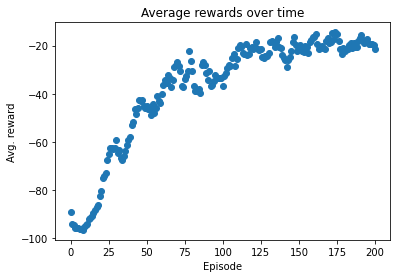

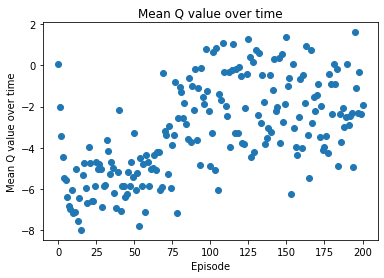

In [13]:
graph_results('DQNDoubleQ', path='data')

In [45]:
get_video(dq_config, "data/DoubleQ/checkpoint-201", "DoubleQ")

2022-04-16 14:16:28,200	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 14:16:28,201	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 14:16:28,278	WARNING util.py:60 -- Install gputil for GPU system monitoring.
2022-04-16 14:16:28,366	INFO trainable.py:534 -- Restored on 172.17.0.2 from checkpoint: data/DoubleQ/checkpoint-201
2022-04-16 14:16:28,386	INFO trainable.py:543 -- Current state after restoring: {'_

### Prioritised Experience Replay

In [14]:
# setup the config, get the last config and set it to use Prioritised Experience Replay
pr_config = config.copy()
# turn on prioritised replay
pr_config['prioritized_replay'] = True
# use the default parameters for prioritised replay
pr_config['prioritized_replay_alpha'] = 0.6
pr_config['prioritized_replay_beta'] = 0.4
pr_config['final_prioritized_replay_beta'] = 0.4
pr_config['prioritized_replay_beta_annealing_timesteps'] = 20000
pr_config['prioritized_replay_eps'] = 1e-6
pr_config['before_learn_on_batch'] = None

# run the training loop
training_loop(pr_config, 'PrioritisedReplay', 'PrioritisedReplay', num_epochs=201, path='data')

2022-04-16 11:35:52,146	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 11:35:52,147	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 11:35:52,249	WARNING util.py:60 -- Install gputil for GPU system monitoring.


Episode 0, mean reward: -92.18181818181819, mean Q: 0.11336681246757507, all rewards: [-100.0, -100.0, -100.0, -100.0, -100.0, -13.0, -100.0, -100.0, -100.0, -101.0, -100.0]
Checkpoint: /root/ray_results/DQNTrainer_AdvancedMapEnv_2022-04-16_11-35-52pxqwzbbl/checkpoint_000001/checkpoint-1
Episode 1, mean reward: -95.9047619047619, mean Q: -1.862654685974121, all rewards: [-100.0, -100.0, -100.0, -100.0, -100.0, -13.0, -100.0, -100.0, -100.0, -101.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Episode 2, mean reward: -97.2258064516129, mean Q: -2.8137497901916504, all rewards: [-100.0, -100.0, -100.0, -100.0, -100.0, -13.0, -100.0, -100.0, -100.0, -101.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Episode 3, mean reward: -96.70731707317073, mean Q: -3.822509288787842, all rewards: [-100.0, -100.0, -100.0, -100.0, -100.0, 

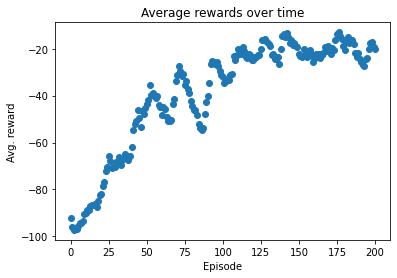

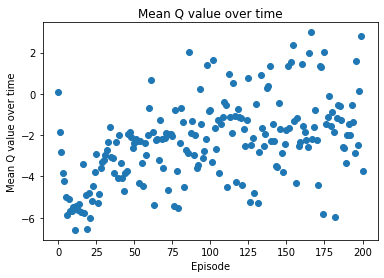

In [15]:
# show the graphs of the results
graph_results('PrioritisedReplay', path='data')

In [47]:
# Get the video
get_video(pr_config, "data/PrioritisedReplay/checkpoint-201", "PrioritisedReplay")

2022-04-16 14:20:40,481	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 14:20:40,482	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 14:20:40,561	WARNING util.py:60 -- Install gputil for GPU system monitoring.
2022-04-16 14:20:40,637	INFO trainable.py:534 -- Restored on 172.17.0.2 from checkpoint: data/PrioritisedReplay/checkpoint-201
2022-04-16 14:20:40,639	INFO trainable.py:543 -- Current state after rest

### Double Q and Prioritised Replay

In [16]:
# setup the config, get the last config and set it to use dueling
bth_config = config.copy()
bth_config['double_q'] = True
# turn on prioritised replay
bth_config['prioritized_replay'] = True
# use the default parameters for prioritised replay
bth_config['prioritized_replay_alpha'] = 0.6
bth_config['prioritized_replay_beta'] = 0.4
bth_config['final_prioritized_replay_beta'] = 0.4
bth_config['prioritized_replay_beta_annealing_timesteps'] = 20000
bth_config['prioritized_replay_eps'] = 1e-6
bth_config['before_learn_on_batch'] = None

# run the training loop
training_loop(bth_config, 'Both', 'Both', num_epochs=201, path='data')

2022-04-16 12:09:09,502	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 12:09:09,505	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 12:09:09,582	WARNING util.py:60 -- Install gputil for GPU system monitoring.


Episode 0, mean reward: -89.0909090909091, mean Q: 0.07197747379541397, all rewards: [-100.0, -100.0, -100.0, -100.0, 20.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Checkpoint: /root/ray_results/DQNTrainer_AdvancedMapEnv_2022-04-16_12-09-09axnh7boo/checkpoint_000001/checkpoint-1
Episode 1, mean reward: -94.28571428571429, mean Q: -1.9670236110687256, all rewards: [-100.0, -100.0, -100.0, -100.0, 20.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Episode 2, mean reward: -96.12903225806451, mean Q: -3.295570135116577, all rewards: [-100.0, -100.0, -100.0, -100.0, 20.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
Episode 3, mean reward: -95.23809523809524, mean Q: -4.563638687133789, all rewards: [-100.0, -100.0, -100.0, -100.0, 20.0, -100

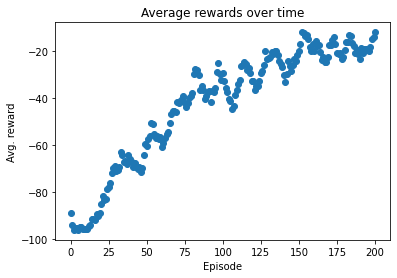

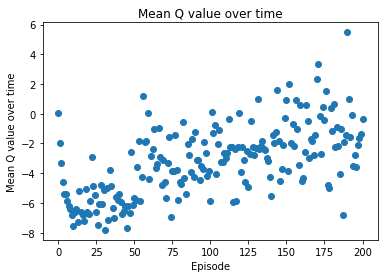

In [18]:
# show the graphs of the results
graph_results('Both', path='data')

In [48]:
# get the video
get_video(bth_config, "data/Both/checkpoint-201","Both")

2022-04-16 14:23:27,112	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 14:23:27,113	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 14:23:27,169	WARNING util.py:60 -- Install gputil for GPU system monitoring.
2022-04-16 14:23:27,233	INFO trainable.py:534 -- Restored on 172.17.0.2 from checkpoint: data/Both/checkpoint-201
2022-04-16 14:23:27,234	INFO trainable.py:543 -- Current state after restoring: {'_ite

In [70]:
#(6,23)
get_video(bth_config, "data/Both/checkpoint-201","Both1")

2022-04-16 15:50:48,935	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 15:50:48,936	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 15:50:49,010	WARNING util.py:60 -- Install gputil for GPU system monitoring.
2022-04-16 15:50:49,069	INFO trainable.py:534 -- Restored on 172.17.0.2 from checkpoint: data/Both/checkpoint-201
2022-04-16 15:50:49,071	INFO trainable.py:543 -- Current state after restoring: {'_ite

In [72]:
get_video(bth_config, "data/Both/checkpoint-201","Both2")

2022-04-16 15:51:35,521	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-04-16 15:51:35,522	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-04-16 15:51:35,661	WARNING util.py:60 -- Install gputil for GPU system monitoring.
2022-04-16 15:51:35,733	INFO trainable.py:534 -- Restored on 172.17.0.2 from checkpoint: data/Both/checkpoint-201
2022-04-16 15:51:35,736	INFO trainable.py:543 -- Current state after restoring: {'_ite

### Combined Results

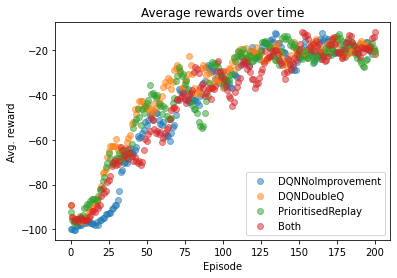

In [49]:
# go into the files
for f in ['DQNNoImprovement', 'DQNDoubleQ', 'PrioritisedReplay', 'Both']:
  # build the dataframe
  source = 'data' # /content/gdrive/My Drive/Colab Notebooks/DRL/DRL Coursework/data
  df = pd.read_csv(f"{source}/{f}.csv")
  # get rid of the useless column
  df.drop("Unnamed: 0", axis=1, inplace=True)

  # Build a graph of the mean rewards over time
  plt.scatter(df.index, df['avg_rewards'], label=f, alpha=0.5)
plt.xlabel("Episode")
plt.ylabel("Avg. reward")
plt.title("Average rewards over time")
plt.legend()
plt.show()

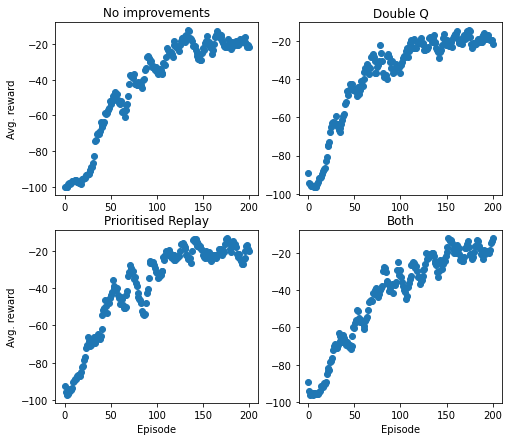

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,7))

# DQNNoImprovement
ax[0][0].scatter("index", "avg_rewards", data=pd.read_csv('data/DQNNoImprovement.csv').drop("Unnamed: 0", axis=1).reset_index())
ax[0][0].set_title("No improvements")
ax[0][0].set_ylabel("Avg. reward")

# Double Q
ax[0][1].scatter("index", "avg_rewards", data=pd.read_csv('data/DQNDoubleQ.csv').drop("Unnamed: 0", axis=1).reset_index())
ax[0][1].set_title("Double Q")

# Prioritised Replay
ax[1][0].scatter("index", "avg_rewards", data=pd.read_csv('data/PrioritisedReplay.csv').drop("Unnamed: 0", axis=1).reset_index())
ax[1][0].set_title("Prioritised Replay")
ax[1][0].set_ylabel("Avg. reward")
ax[1][0].set_xlabel("Episode")

# Both
ax[1][1].scatter("index", "avg_rewards", data=pd.read_csv('data/Both.csv').drop("Unnamed: 0", axis=1).reset_index())
ax[1][1].set_title("Both")
ax[1][1].set_xlabel("Episode")

plt.show()

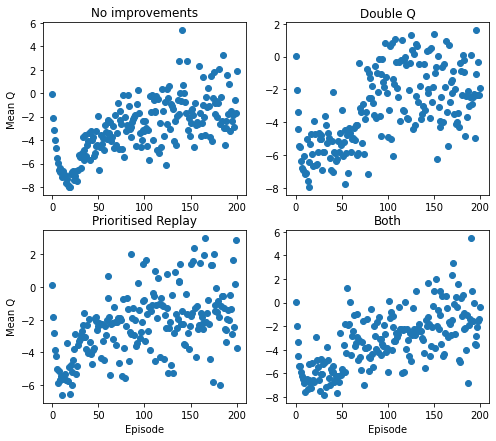

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,7))

# DQNNoImprovement
ax[0][0].scatter("index", "mean_q", data=pd.read_csv('data/DQNNoImprovement.csv').drop("Unnamed: 0", axis=1).reset_index())
ax[0][0].set_title("No improvements")
ax[0][0].set_ylabel("Mean Q")

# Double Q
ax[0][1].scatter("index", "mean_q", data=pd.read_csv('data/DQNDoubleQ.csv').drop("Unnamed: 0", axis=1).reset_index())
ax[0][1].set_title("Double Q")

# Prioritised Replay
ax[1][0].scatter("index", "mean_q", data=pd.read_csv('data/PrioritisedReplay.csv').drop("Unnamed: 0", axis=1).reset_index())
ax[1][0].set_title("Prioritised Replay")
ax[1][0].set_ylabel("Mean Q")
ax[1][0].set_xlabel("Episode")

# Both
ax[1][1].scatter("index", "mean_q", data=pd.read_csv('data/Both.csv').drop("Unnamed: 0", axis=1).reset_index())
ax[1][1].set_title("Both")
ax[1][1].set_xlabel("Episode")

plt.show()